In [1]:
%matplotlib inline
from scipy import stats
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm

import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# load R
%load_ext rpy2.ipython

plt.rcParams['figure.figsize'] = [15, 10]

# Load the data

In [2]:
data = pd.read_csv('Scores.csv')
data.head(3)

,Test1,Test2,Test3,JobScore
0,84,52,92,81
1,63,54,88,72
2,69,50,91,75


# Fit and state the multiple linear regression model: 
You do not need to do any modification of the model such as variable selection.

In [3]:
model = smf.ols("JobScore ~ Test1 + Test2 + Test3", data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               JobScore   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     25.16
Date:                Sat, 29 Apr 2017   Prob (F-statistic):           2.67e-07
Time:                        14:23:59   Log-Likelihood:                -64.960
No. Observations:                  26   AIC:                             137.9
Df Residuals:                      22   BIC:                             143.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.8885     11.906      0.663      0.515     -16.804      32.581
Test1          0.1627      0.072      2.267      0.034       0.014       0.312
Test2          0.4105      0.065      6.336      0.000       0.276       0.545
Test3          0.3545      0.137      2.594      0.017       0.071       0.638
==============================================================================
Omnibus:                        0.914   Durbin-Watson:                   1.629
Prob(Omnibus):                  0.633   Jarque-Bera (JB):                0.376
Skew:                          -0.293   Prob(JB):                        0.829
Kurtosis:                       3.069   Cond. No.                     2.44e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Are the assumptions of linear regression met?
State the assumptions and how you know they are or are not met. You can assume independence.  Include graphs where necessary to support your argument.  If you determine that an assumption is not met, you do not need to attempt to fix the problem.  Complete parts a, c, and d as if the assumptions are met, regardless.

## Description of the data
It seems all of the variables have the roughly same range and not boo big difference in the distributions

In [4]:
data.describe()

,Test1,Test2,Test3,JobScore
count,26.000000,26.000000,26.000000,26.000000
mean,72.384615,55.346154,90.153846,74.346154
std,9.165487,10.376675,4.977488,6.317862
min,53.000000,36.000000,79.000000,62.000000
25%,65.750000,49.250000,88.250000,71.000000
50%,74.000000,54.000000,90.500000,74.000000
75%,78.000000,61.250000,93.750000,77.750000
max,88.000000,84.000000,99.000000,88.000000


## Inspect the distributions for Normality:
The distributions of all test types look roughly normally distributed. QQ plots look in a line. 

---
I will say assumption for Normality is met

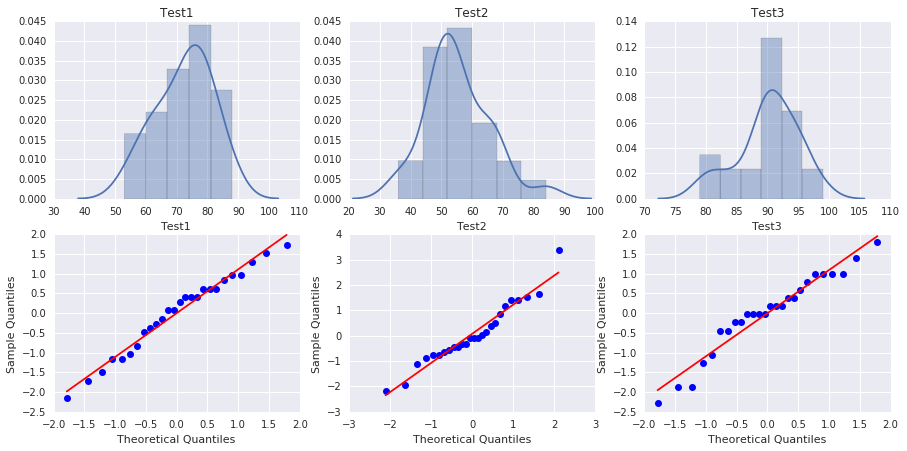

In [5]:
f, ax = plt.subplots(nrows=2, ncols=3, figsize=[15, 7])
for i, column in enumerate(['Test1','Test2','Test3']):
    ax[0][i].set_title(column)
    sns.distplot(data[column], ax=ax[0][i])
    sm.graphics.qqplot(data[column], dist=stats.t, line='r', fit=True, ax=ax[1][i])

## Check for linear relationship between the test scores and the JobScore
All the tests show that could fit a line when compared to the JobScore and the reletionship looks week but linear

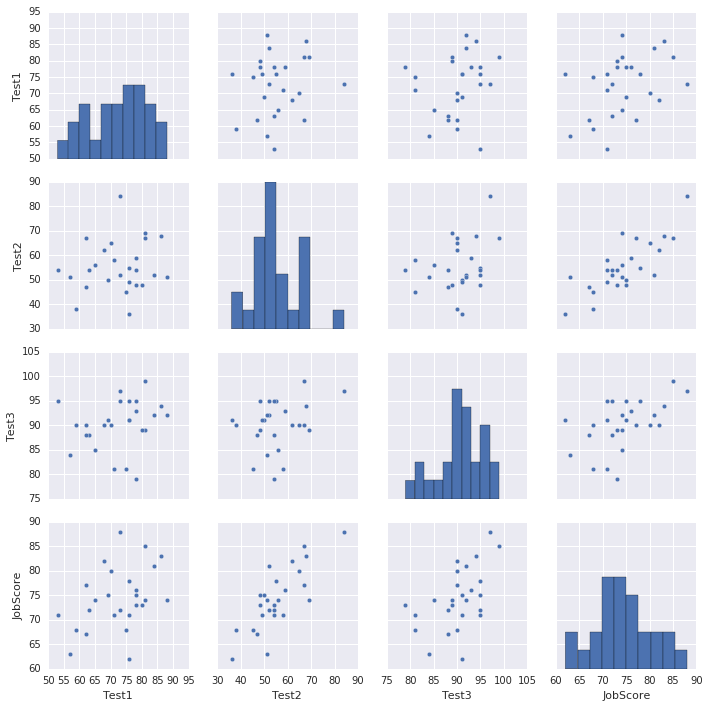

In [6]:
sns.pairplot(data);

## Inspect for high - influance points
There are two points with a little higher influance but they are just a little higher and don't wory me.

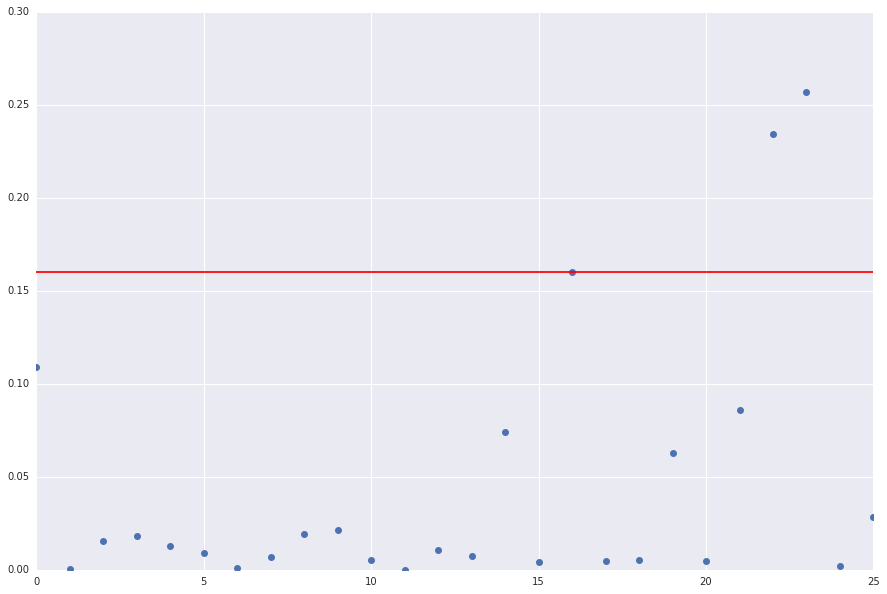

In [7]:
influence = model.get_influence()
influence_summary = influence.summary_frame()
plt.plot(influence_summary.index, influence_summary['cooks_d'], 'o')
plt.axhline(y=4/(len(data)-1), color='r', linestyle='-')

## Multicollinearity check
The three variables have very high variance inflation factor! This is something that should be looked at more closely

In [8]:
X = data[['Test1','Test2','Test3']]
vif = {}
for i, column in enumerate(X.columns):
    vif[column] = variance_inflation_factor(X.values, i)
pd.DataFrame([vif])

,Test1,Test2,Test3
0,66.157986,33.740448,90.512676


### Chech the Pearson's correlation coefficient
The correlation is is not high between the variables. I am questioning my results in the previous variance inflation results.

In [9]:
from itertools import combinations

for combination in combinations(['Test1','Test2','Test3'], 2):
    c1, c2 = combination
    corr, pvalue = stats.pearsonr(data[c1], data[c2])
    print(c1, 'VS', c2, 'correlation:', corr, '2-tailed p-value', pvalue)

Test1 VS Test2 correlation: 0.149110964922 2-tailed p-value 0.467222320182
Test1 VS Test3 correlation: 0.213463978806 2-tailed p-value 0.295074200716
Test2 VS Test3 correlation: 0.293217461726 2-tailed p-value 0.146010772901


## Interpret the slope for Test1 
(you do not need to interpret the other slopes or the intercept).

---

With an increase of 1 in Test1 score the JobScore is <b>expected</b> to increase with 0.1627. Due to uncertanty in the model, the actual JobScore will vary and the model is 95% confident that the true increase in JobScore will be in the interval of (0.014, 0.312)

## Extra Credit:
Say a new applicant takes the three tests and gets 58, 67, and 89 on Tests 1, 2, and 3, respectively. Give a 95% interval in which you would expect their JobScore to fall and interpret that interval.

In [10]:
new_data = pd.DataFrame([dict(Test1=58, Test2=67, Test3=89)])
%R -i data -i new_data 
%R model <- lm(JobScore ~ Test1 + Test2 + Test3, data=data)
%R prediction_intervals <- predict(model, new_data, interval="predict", alpha=0.05)
%R -o prediction_intervals
interval = prediction_intervals[0, [1,2]]

print("We are 95% confident that the JobScore will fall in the interval:", interval)

We are 95% confident that the JobScore will fall in the interval: [69.065012343555182, 83.695834044722616]
